In [4]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler, startingZeros

In [2]:
# saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation'
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation/Data/model-20000
Save restored


In [5]:
NUM_VOX = 150
TARGET_NUM_VOX = 96
ADVERSARIAL_REGULARIZATION = 1e0
TIKHONOV_REGULARIZATION = 1e5
IMAGING_SCALE = 300
STEP_SIZE_NOMINAL = 1e-4

IT = 12

path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/ClassicalRelionWithExtReco/run_it' + startingZeros(IT) + '_half2_class001_external_reconstruct.star'
pathRel = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/ClassicalRelionWithExtReco/run_it' + startingZeros(IT) + '_half2_class001.mrc'
#path = '/local/scratch/public/sl767/MRC_Data/RealLife/A2A_VPP/Refine3D/job001/run_it005_half2_class001_external_reconstruct.star'
file=load_star(path)
with mrcfile.open(pathRel) as mrc:
    rel_reco = mrc.data.copy()

In [6]:
def vis(data, fourier=True, slice=NUM_VOX//2):
    if fourier:
        data = irfft(data, scaling=NUM_VOX**2)
    plt.imshow(data.squeeze()[..., slice])

Kernel max before rescaling: 7.9542e+07
1.07958


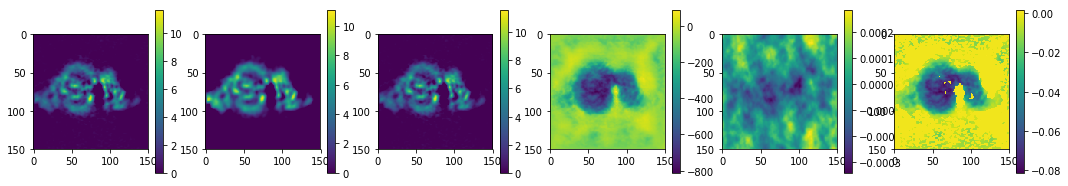

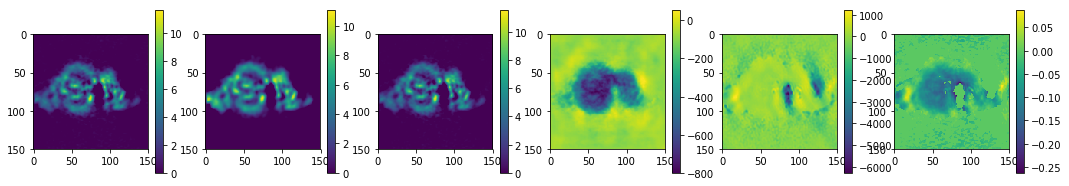

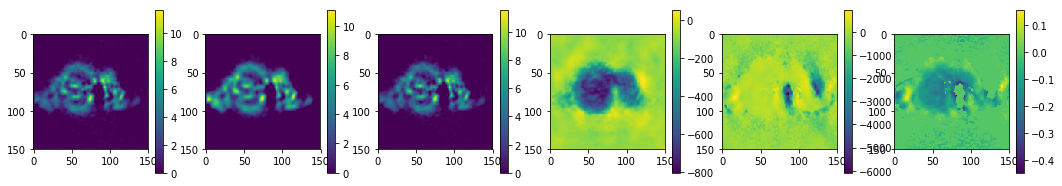

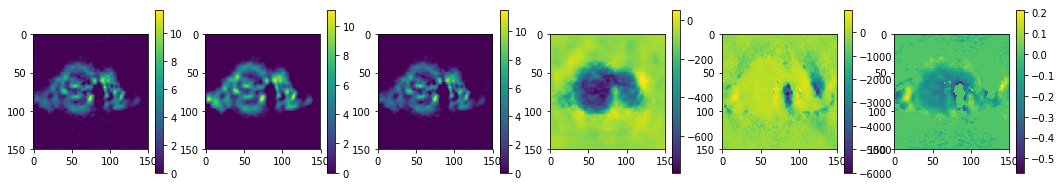

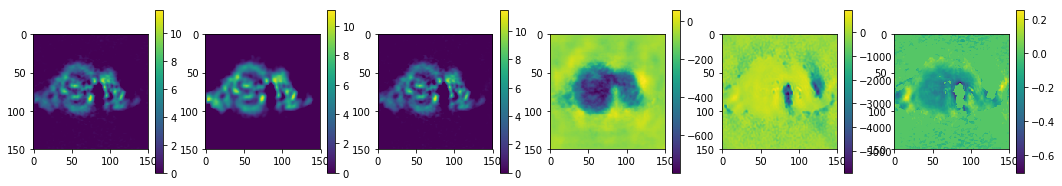

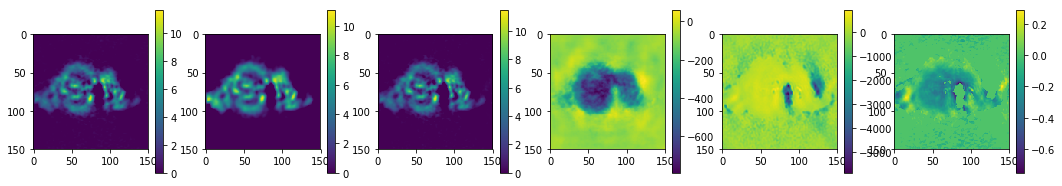

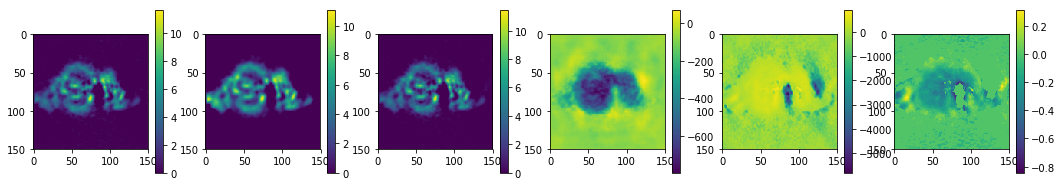

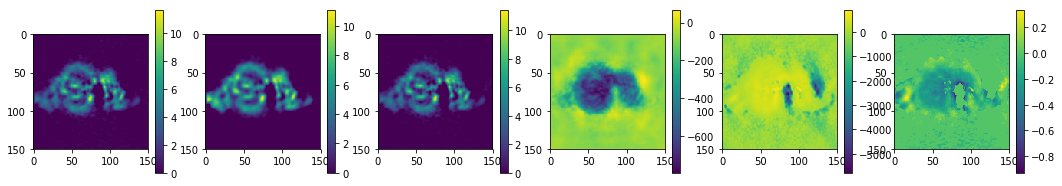

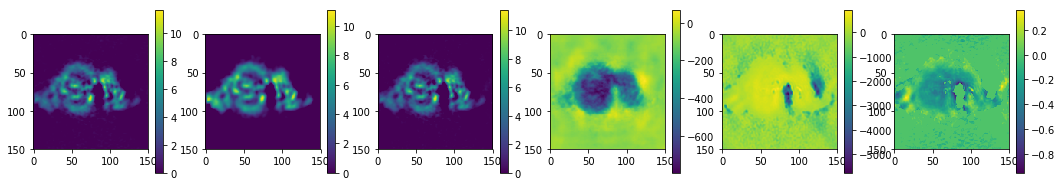

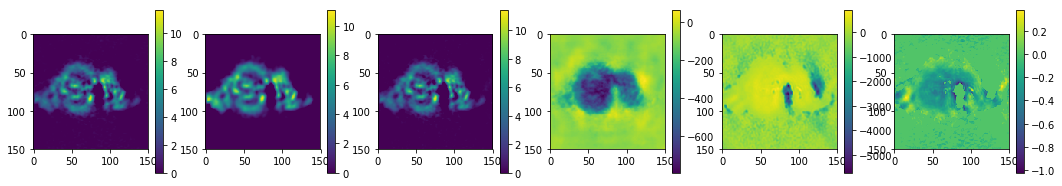

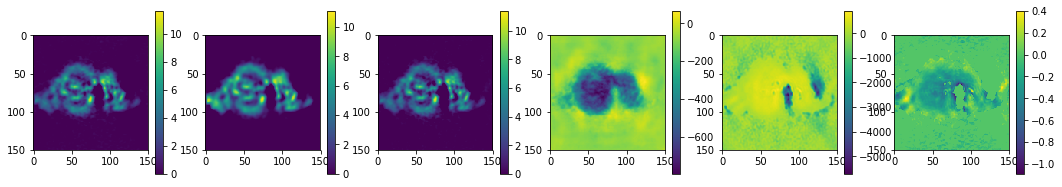

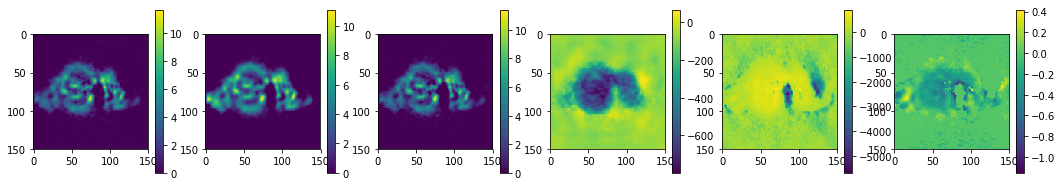

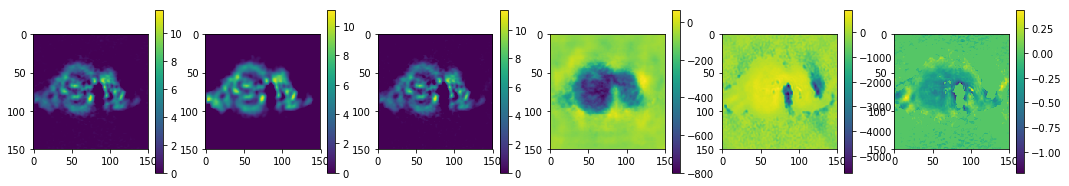

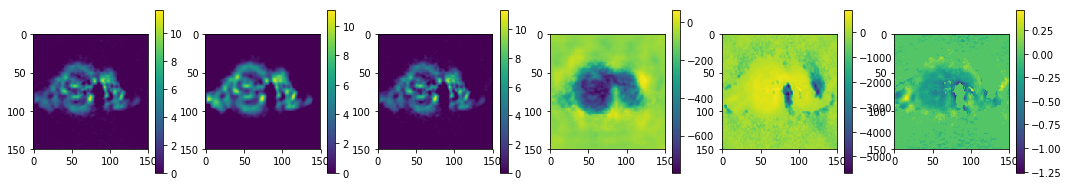

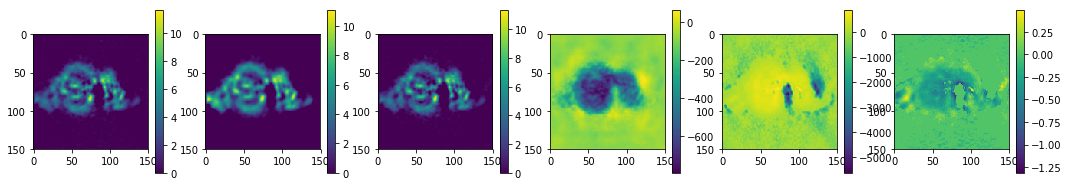

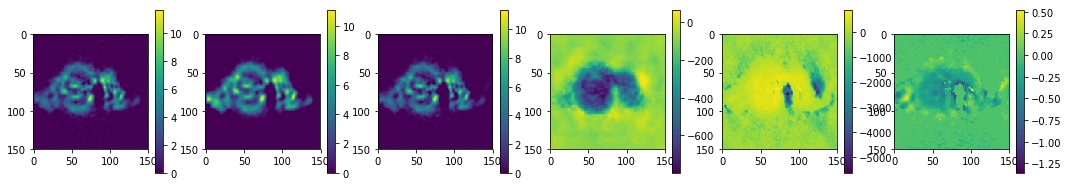

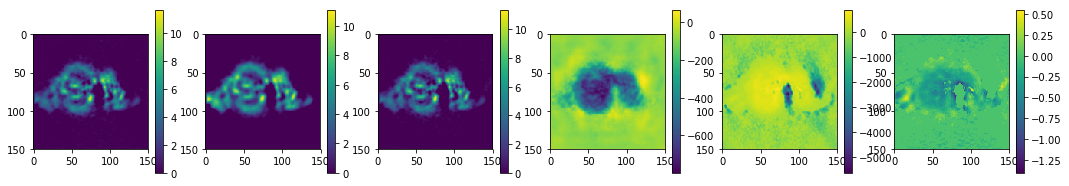

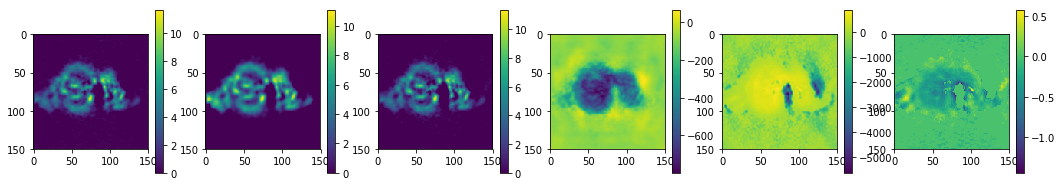

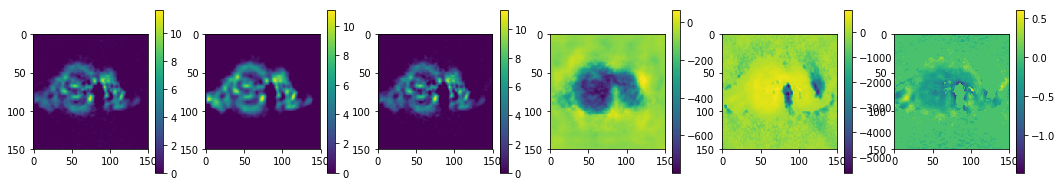

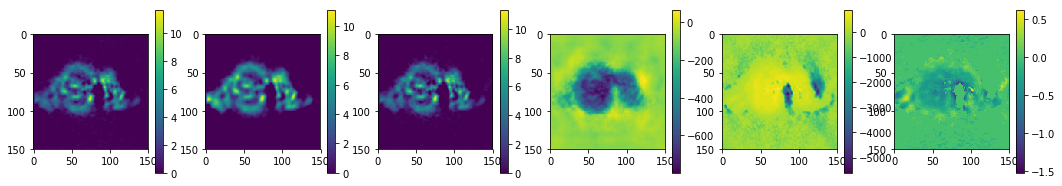

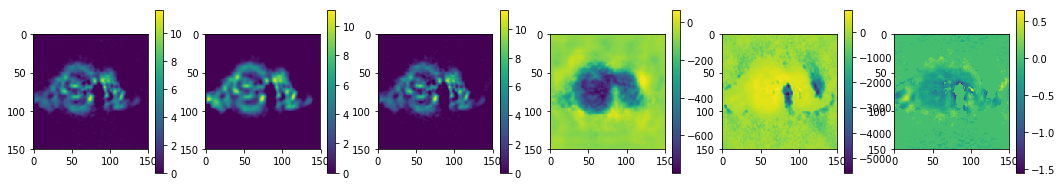

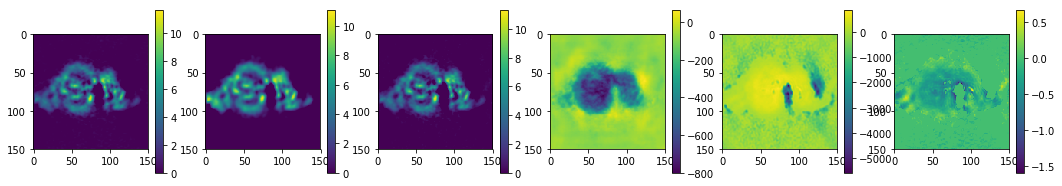

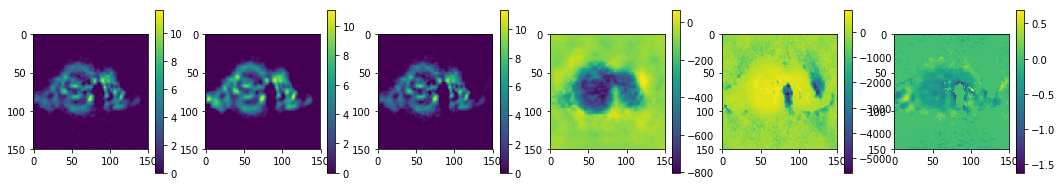

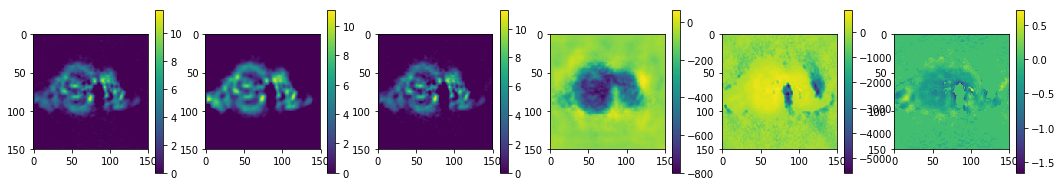

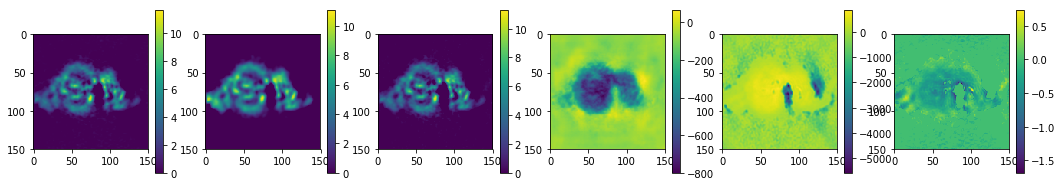

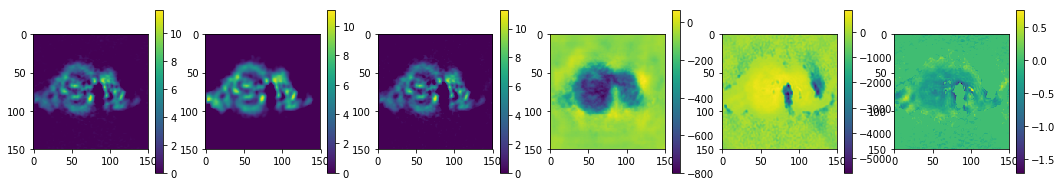

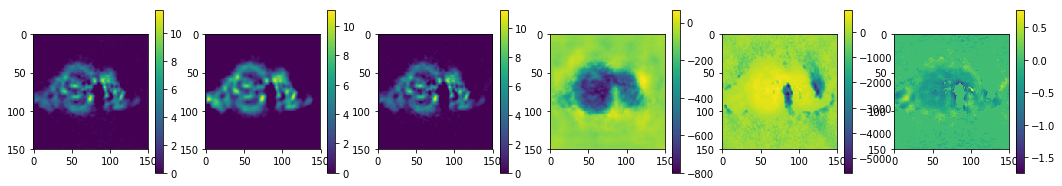

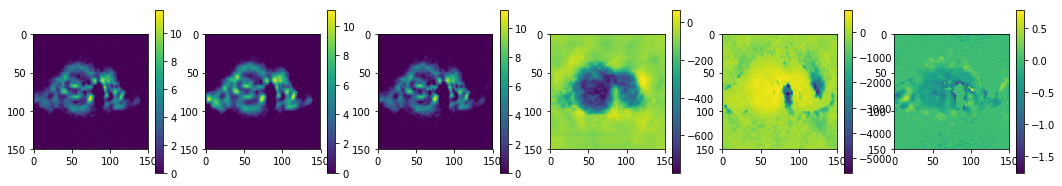

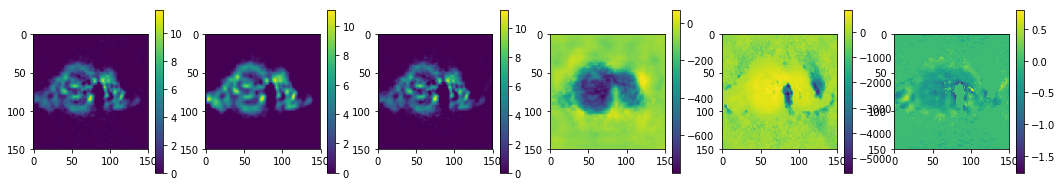

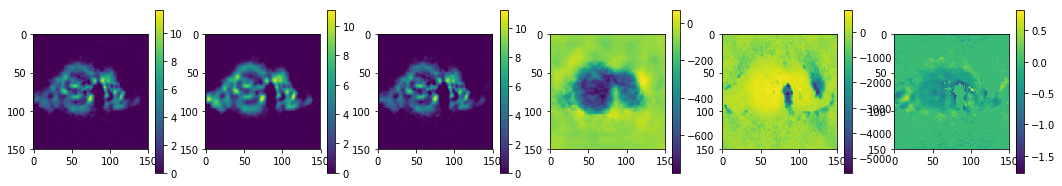

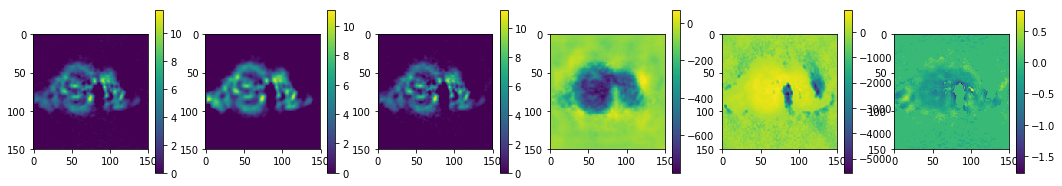

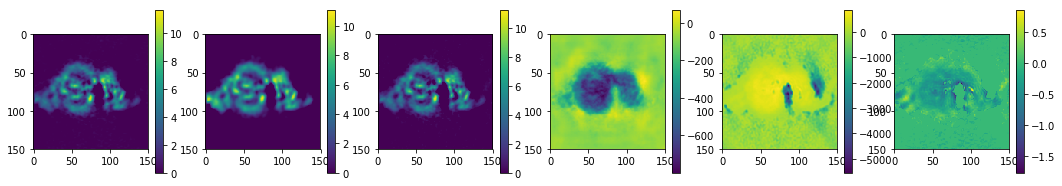

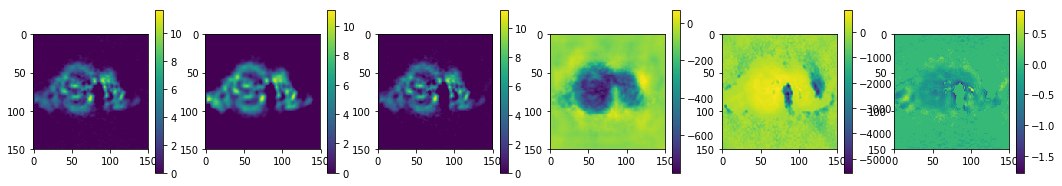

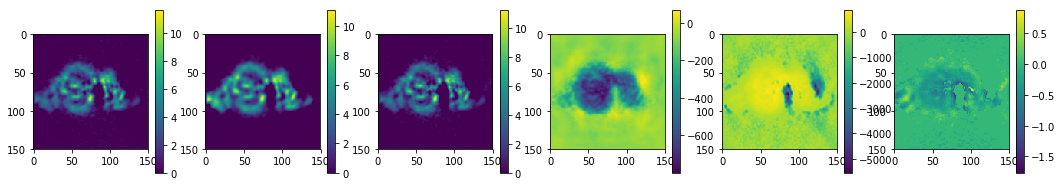

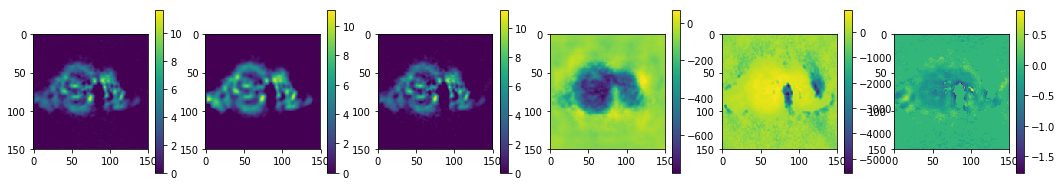

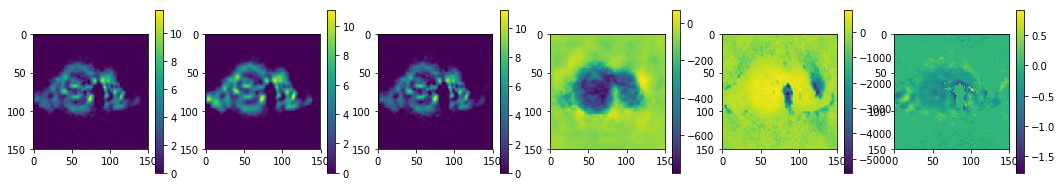

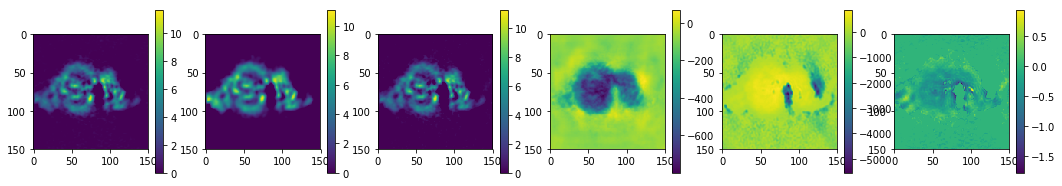

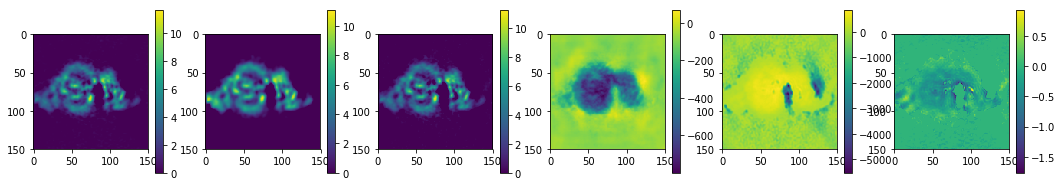

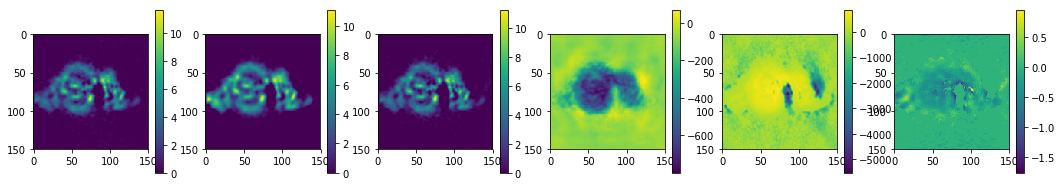

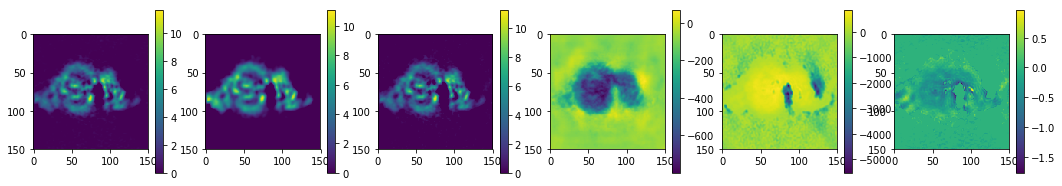

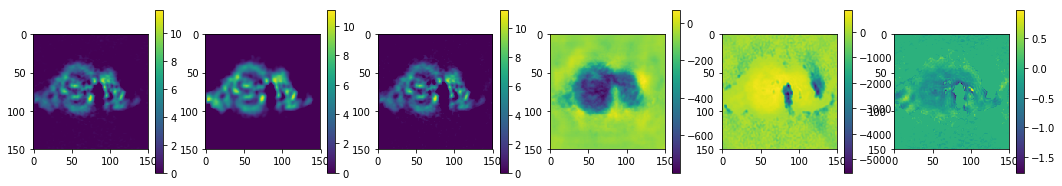

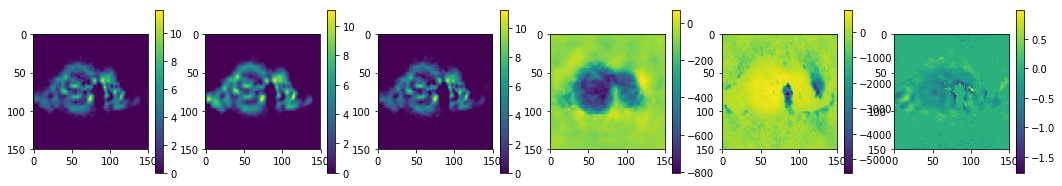

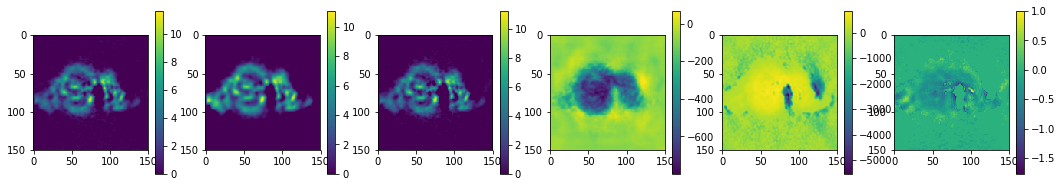

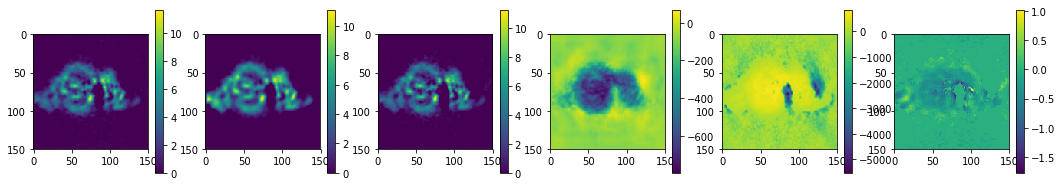

KeyboardInterrupt: 

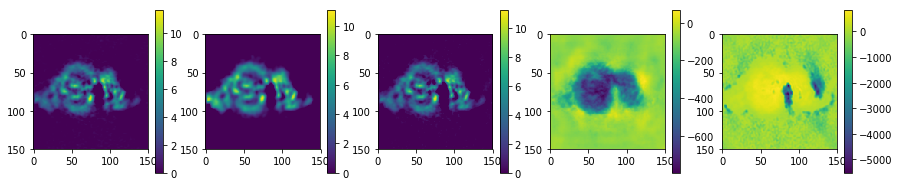

In [89]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()

complex_data=data_real + 1j * data_im

complex_data_norm = np.mean(irfft(complex_data, scaling=NUM_VOX**2))
#print(complex_data_norm)
print('Kernel max before rescaling: ' + str(np.abs(kernel).max()))
#raise Exception
tikhonov_kernel = kernel + TIKHONOV_REGULARIZATION
complex_data /= complex_data_norm
tikhonov_kernel /= complex_data_norm
kernel /= complex_data_norm
#print('Max/min for tik_kernel: ', np.max(np.abs(tikhonov_kernel)), np.min(np.abs(tikhonov_kernel)))

#raise Exception
precond = np.abs(np.divide(1, kernel + TIKHONOV_REGULARIZATION))
precond /= precond.max()
print(precond.max()/precond.min())
#precond = 1
#raise Exception
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

for k in range(700):
    STEP_SIZE = STEP_SIZE_NOMINAL / np.sqrt(1 + k / 20)
    
    ###############
    # DOWNSAMPLING
    reco_ds = np.copy(reco)
    reco_ds = np.fft.fftshift(reco_ds, axes=(0,1))
    reco_ds = reco_ds[NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 
                      NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 
                      0:(TARGET_NUM_VOX//2)+1]
    reco_ds = np.fft.ifftshift(reco_ds, axes=(0,1))
    ###############
     
    gradient_tmp = regularizer.evaluate(reco_ds)

    ###############
    # UPSAMPLING
    gradient = np.zeros_like(complex_data)
    gradient[NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 
             NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 
             0:(TARGET_NUM_VOX//2)+1] = np.fft.fftshift(gradient_tmp, axes=(0,1))
    gradient = np.fft.ifftshift(gradient, axes=(0,1))
    ###############
    g1 = ADVERSARIAL_REGULARIZATION * gradient
    g2 = (np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
    reco = reco - STEP_SIZE * precond * g
    reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    if k%1 == 0:
#        print(np.max(irfft(reco, scaling=NUM_VOX**2)))
        plt.figure(k, figsize=(18, 3))
        plt.subplot(161)
        vis(IMAGING_SCALE*np.fft.rfftn(np.maximum(0, np.fft.irfftn(tikhonov))))
        plt.colorbar()
        plt.subplot(162)
        vis(IMAGING_SCALE*np.maximum(0, rel_reco), fourier=False)
        plt.colorbar()
        plt.subplot(163)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(164)
        vis(-IMAGING_SCALE*precond*g1)
        plt.colorbar()
        plt.subplot(165)
        vis(-IMAGING_SCALE*precond*g2)
        plt.colorbar()
        plt.subplot(166)
        vis(IMAGING_SCALE*(reco - np.fft.rfftn(np.maximum(0, np.fft.irfftn(tikhonov)))))
        plt.colorbar()
        plt.show()

In [ ]:
np.mean(kernel)

In [ ]:
def l2_gt(x):
    image=unify_form(np.copy(x))
    r=Rescaler(image)
    r.normalize(image)
    reg=Registrator.register(image=image, reference=ground_truth)
    return l2(reg-ground_truth)

In [ ]:
def evaluate(reg):
    ADVERSARIAL_REGULARIZATION = reg

    #print(np.max(kernel))
    #print(np.min(kernel))
    #raise Exception


    tikhonov_kernel = kernel + 1e6
    precondioner = np.abs(np.divide(1, tikhonov_kernel))
    precondioner /= precondioner.max()
    tikhonov = np.divide(complex_data, tikhonov_kernel)
    reco = np.copy(tikhonov)

    ###############
    # DOWNSAMPLING
    reco_ds = np.copy(tikhonov)
    reco_ds = np.fft.fftshift(reco_ds, axes=(0,1))[NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 0:(TARGET_NUM_VOX//2)+1]
    reco_ds = np.fft.ifftshift(reco_ds, axes=(0,1))
    ###############


    # The scales produce gradients of order 1
    ADVERSARIAL_SCALE=(96**(-0.5))
    DATA_SCALE=1/(10*96**3)

    IMAGING_SCALE=96

    for k in range(70):
        STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)

        gradient_tmp = regularizer.evaluate(reco_ds)
        ###############
        # UPSAMPLING
        gradient = np.zeros_like(complex_data)
        gradient[NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, NUM_VOX//2-TARGET_NUM_VOX//2 : NUM_VOX//2+TARGET_NUM_VOX//2, 0:(TARGET_NUM_VOX//2)+1] = np.fft.fftshift(gradient_tmp, axes=(0,1))
        gradient = np.fft.ifftshift(gradient, axes=(0,1))
        ###############
        g1 = ADVERSARIAL_REGULARIZATION * gradient * ADVERSARIAL_SCALE
    #     print(l2(gradient))
        g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)

        g = g1 + g2
    #     reco = reco - STEP_SIZE * 0.02 * g
        reco = reco - STEP_SIZE * precondioner * g

        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))

    return l2_gt(irfft(reco))

In [ ]:
parameters = [0.0, 0.001, 0.003, 0.01, 0.03, 0.1]
results = {}
for reg in parameters:
    results['Reg_{}'.format(reg)] = evaluate(reg = reg)

In [ ]:
print(results)

# Optimal parameters:

- SNR .02, first iterate: .03 --> Improvement .015
- SNR .02, 10th iterate: .05 --> Improvement .081
- SNR .01, first iterate: .005 (reasonable till .01) --> Improvement .002
- SNR .01, 10th: .005 (reasonable till .01) --> Improvement .002
- SNR .012, first iterate: .01 --> Improvement .006
- SNR .012, 10th iterate: .01 --> Improvement .006
- SNR .016, first iterate: .02 --> Improvement .012
- SNR .016, 10th: .03 --> Improvement .042

In [15]:
for l, item in res1.items():
    print(l)
    print(item)

Reg_0.0
0.926861
Reg_0.001
0.926727
Reg_0.002
0.926671
Reg_0.005
0.926822
Reg_0.01
0.928034


# Results for 10th iterate, SNR .01

In [25]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.96947
Reg_0.001
0.968683
Reg_0.002
0.968957
Reg_0.005
0.968748
Reg_0.01
0.968847
Reg_0.02
0.972109
Reg_0.05
1.00863


# Results for 01st iterate, SNR .02

In [32]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.786947
Reg_0.001
0.78646
Reg_0.002
0.785675
Reg_0.005
0.784036
Reg_0.01
0.782251
Reg_0.02
0.78097
Reg_0.05
0.793211


# Results for 10th iterate, SNR .02

In [42]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.629159
Reg_0.001
0.62979
Reg_0.002
0.626202
Reg_0.005
0.624027
Reg_0.01
0.618987
Reg_0.02
0.610808
Reg_0.05
0.60086


In [9]:
import mrcfile
from ClassFiles.relion_fixed_it import load_star
import numpy as np
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler, startingZeros
NUM_VOX = 150
for k in range(1, 10):
    path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/ClassicalRelionWithExtReco/run_it00{}_half2_class001_external_reconstruct.star'.format(k)
    #path = '/local/scratch/public/sl767/MRC_Data/RealLife/A2A_VPP/Refine3D/job001/run_it005_half2_class001_external_reconstruct.star'
    file=load_star(path)
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
        data_real = mrc.data.copy()
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
        data_im = mrc.data.copy()
    with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
        kernel = mrc.data.copy()
    #with mrcfile.open(locate_gt(PDB_ID, full_path=False)) as mrc:
    #    ground_truth = mrc.data.copy()
    #with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
    #    naive_recon = mrc.data.copy()

    #ground_truth = unify_form(ground_truth)
    #r_gt = Rescaler(ground_truth)
    #r_gt.normalize(ground_truth)

    complex_data=data_real + 1j * data_im
    print(np.sum(np.abs(complex_data) ** 2), np.sum(irfft(complex_data, scaling=NUM_VOX**2)))
    print(np.sum(np.abs(kernel) ** 2), np.sum(irfft(kernel, scaling=NUM_VOX**2)))
    print("*****************************")

6.39688e+14 5.23431e+11
1.71599e+18 4.36590970854e+12
*****************************
3.17172e+13 7.96593e+09
3.38361e+18 87974997570.1
*****************************
7.49241e+13 2.56683e+10
1.10697e+19 228045318669.0
*****************************
8.82628e+13 3.74931e+10
1.90396e+19 341302351296.0
*****************************
8.98023e+13 3.35047e+10
2.12502e+19 308109303169.0
*****************************
9.08895e+13 3.48127e+10
4.08397e+19 319354904129.0
*****************************
8.76521e+13 3.28812e+10
3.51745e+19 299079526799.0
*****************************
9.0566e+13 3.36494e+10
2.93157e+19 306727556236.0
*****************************
9.12684e+13 3.33172e+10
3.31246e+19 304062444476.0
*****************************


In [101]:
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/no_precond_reg_par_5/run_it001_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp = mrc.data.copy()

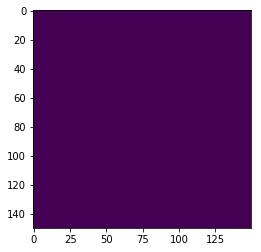

In [94]:
vis(tmp, fourier=False)

In [92]:
np.sum(np.abs(tmp) ** 2)


0.0

In [25]:
tmp.shape

(150, 150, 150)

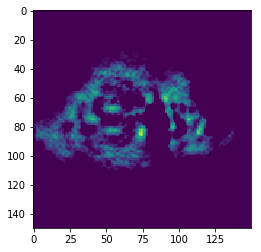

In [11]:
import mrcfile
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/seb_pars/run_it012_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp = mrc.data.copy()
vis(tmp, fourier=False)

0.021612


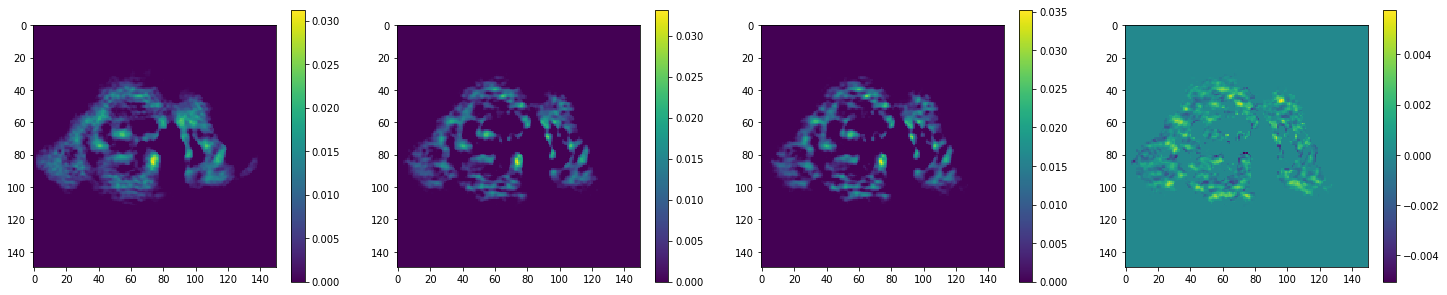

In [8]:
import mrcfile
from matplotlib import pyplot as plt
from ClassFiles.ut import irfft
NUM_VOX = 150
def vis(data, fourier=True, slice=NUM_VOX//2):
    if fourier:
        data = irfft(data, scaling=NUM_VOX**2)
    plt.imshow(data.squeeze()[..., slice])
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/seb_pars_2/run_it008_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp = mrc.data.copy()
plt.figure(figsize=(25,5))
plt.subplot(141)
vis(tmp, fourier=False)
plt.colorbar()
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/seb_pars_2/run_it010_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp2 = mrc.data.copy()
plt.subplot(142)
vis(tmp2, fourier=False)
plt.colorbar()
path = '/local/scratch/public/sl767/MRC_Data/RealLifeAR/A2A_VPP/seb_pars_2/run_it011_half2_class001.mrc'
with mrcfile.open(path) as mrc:
    tmp3 = mrc.data.copy()
plt.subplot(143)
vis(tmp3, fourier=False)
plt.colorbar()
plt.subplot(144)
vis(tmp3-tmp2, fourier=False)
plt.colorbar()
print(((tmp3-tmp2) ** 2).sum()/(tmp3**2).sum())


In [ ]:
plt.colorbar()